# ENPM690 Project: Quadcopter control using Deep Deterministic Policy Gradiet(DDPG)


In [1]:
import random

class Basic_Agent():
    
    def __init__(self, task):
        self.task = task
    
    def act(self):
        new_thrust = random.gauss(450., 25.)
        return [new_thrust + random.gauss(0., 1.) for x in range(4)]

`runtime`, `init_pose`, `init_velocities`, and `init_angle_velocities` below to change the starting conditions of the quadcopter.


In [2]:
%load_ext autoreload
%autoreload 2

import csv
import numpy as np

from task import Task

# the values below can be modified to give the quadcopter a different starting position

runtime = 5.                                     
init_pose = np.array([0., 0., 0., 0., 0., 0.])  
init_velocities = np.array([0., 0., 0.])         
init_angle_velocities = np.array([0., 0., 0.])   
file_output = 'data.txt'                         


task = Task(init_pose, init_velocities, init_angle_velocities, runtime)
agent = Basic_Agent(task)
done = False

labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']

results = {x : [] for x in labels}

# simulation
with open(file_output, 'w') as csvfile:
    
    writer = csv.writer(csvfile)
    writer.writerow(labels)
    
    while True:
        
        rotor_speeds = agent.act()
        _, _, done = task.step(rotor_speeds)
        to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(rotor_speeds)
        
        for ii in range(len(labels)):
            results[labels[ii]].append(to_write[ii])
        writer.writerow(to_write)
        
        if done:
            break

Setting default init pose


Visualizing the position of the Quadcopter evolved during the simulation:-

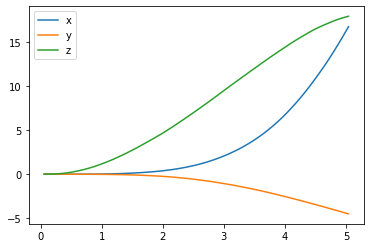

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(results['time'], results['x'], label='x')
plt.plot(results['time'], results['y'], label='y')
plt.plot(results['time'], results['z'], label='z')
plt.legend()
_ = plt.ylim()

Visualizing the velocity of the Quadcopter:-

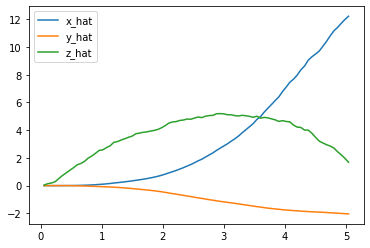

In [4]:
plt.plot(results['time'], results['x_velocity'], label='x_hat')
plt.plot(results['time'], results['y_velocity'], label='y_hat')
plt.plot(results['time'], results['z_velocity'], label='z_hat')
plt.legend()
_ = plt.ylim()

Visualizing the Euler angles (the rotation of the Quadcopter over the $x$-, $y$-, and $z$-axes),

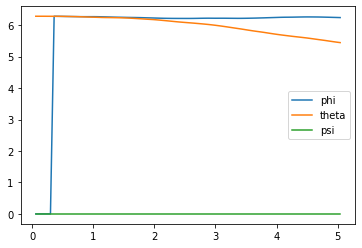

In [5]:
plt.plot(results['time'], results['phi'], label='phi')
plt.plot(results['time'], results['theta'], label='theta')
plt.plot(results['time'], results['psi'], label='psi')
plt.legend()
_ = plt.ylim()

Velocities (in radians per second) corresponding to each of the Euler angles:-

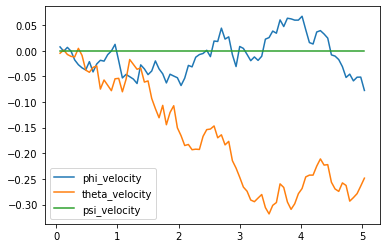

In [6]:
plt.plot(results['time'], results['phi_velocity'], label='phi_velocity')
plt.plot(results['time'], results['theta_velocity'], label='theta_velocity')
plt.plot(results['time'], results['psi_velocity'], label='psi_velocity')
plt.legend()
_ = plt.ylim()

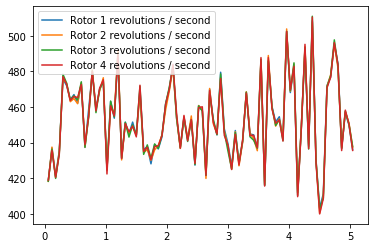

In [7]:
plt.plot(results['time'], results['rotor_speed1'], label='Rotor 1 revolutions / second')
plt.plot(results['time'], results['rotor_speed2'], label='Rotor 2 revolutions / second')
plt.plot(results['time'], results['rotor_speed3'], label='Rotor 3 revolutions / second')
plt.plot(results['time'], results['rotor_speed4'], label='Rotor 4 revolutions / second')
plt.legend()
_ = plt.ylim()

In [8]:
# the pose, velocity, and angular velocity of the quadcopter at the end of the episode
print(task.sim.pose)
print(task.sim.v)
print(task.sim.angular_v)

[16.79291086 -4.51931641 17.98105464  6.24062408  5.44497698  0.        ]
[12.2164766  -2.03996018  1.68741903]
[-0.07749848 -0.24856423  0.        ]


### Less efficient initially:-

In [9]:
import sys
import pandas as pd

from agents.policy_search import PolicySearch_Agent
from task import Task

num_episodes = 500
target_pos = np.array([0., 0., 500.])

task = Task(target_pos=target_pos)
agent = PolicySearch_Agent(task) 

for i_episode in range(1, num_episodes+1):
    state = agent.reset_episode()
    
    while True:
        action = agent.act(state) 
        next_state, reward, done = task.step(action)
        agent.step(reward, done)
        state = next_state
        
        if done:
            print("\rEpisode = {:4d}, score = {:7.3f} (best = {:7.3f}), noise_scale = {}".format(
                i_episode, agent.score, agent.best_score, agent.noise_scale), end="")  # [debug]
            break
    
    sys.stdout.flush()

Episode =  500, score =   4.429 (best =   4.429), noise_scale = 1.655

The agent performed poorly on this task.

### DDPG Actor Critic Agent trained on the Improved Task:-

In [10]:
import sys
import pandas as pd

from agents.agent import DDPG
from tasks.takeoff import Task
import csv


num_episodes = 500
target_pos = np.array([0., 0., 100.])
task = Task(target_pos=target_pos)
agent = DDPG(task) 

worst_score = 1000000
best_score = -1000000.
reward_log = "reward.txt"

reward_labels = ['episode', 'reward']
reward_results = {x : [] for x in reward_labels}

Using TensorFlow backend.
/home/varsha/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/varsha/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/varsha/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/varsha/anaconda3/lib/python3.7/site-packages/tenso

In [11]:

for i_episode in range(1, num_episodes+1):
    state = agent.reset_episode() 
    score = 0
    
    while True:
        
        action = agent.act(state) 
        next_state, reward, done = task.step(action)
        agent.step(action, reward, next_state, done)
        state = next_state
        
        score += reward
        best_score = max(best_score , score)
        worst_score = min(worst_score , score)
        
        if done:
            print("\rEpisode = {:4d}, score = {:7.3f} (best = {:7.3f} , worst = {:7.3f})".format(
               i_episode, score, best_score, worst_score), end="")
            break
    
    reward_results['episode'].append(i_episode)
    reward_results['reward'].append(score)
    
    sys.stdout.flush()


Episode =  500, score = 112.549 (best = 570.293 , worst =   6.439)

## Plotting the Rewards:-
 

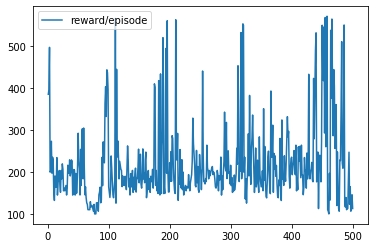

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(reward_results['episode'], reward_results['reward'], label='reward/episode')
plt.legend()
_ = plt.ylim()

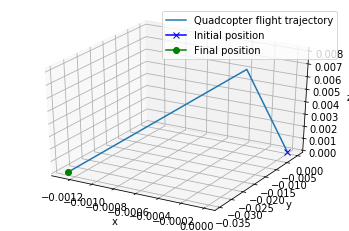

In [13]:
file_output = 'ddpg_agent_takeoff_sim.txt'                         

runtime = 5.  
init_pose = np.array([0., 0., 0., 0., 0., 0.])   
init_velocities = np.array([0., 0., 0.])         
init_angle_velocities = np.array([0., 0., 0.])  

target_pos = np.array([0., 0., 0.])
task = Task(init_pose, init_velocities, init_angle_velocities, runtime, target_pos)

done = False

labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']

results = {x: [] for x in labels}



with open(file_output, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)
    
    while True:
        state = agent.reset_episode()
        rotor_speeds = agent.act(state)
        _, _, done = task.step(rotor_speeds)
        to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(rotor_speeds)
        
        for ii in range(len(labels)):
            results[labels[ii]].append(to_write[ii])
        writer.writerow(to_write)
        
        if done:
            break


In [ ]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
    
mpl.rcParams['legend.fontsize'] = 10

fig = plt.figure()
ax = fig.gca(projection='3d', xlabel='x', ylabel='y', zlabel='z')
x = np.append(init_pose[0], results['x'])
y = np.append(init_pose[1], results['y'])
z = np.append(init_pose[2], results['z'])
final_idx = len(x)-1
ax.plot(x, y, z, label='Quadcopter flight trajectory')
ax.plot([init_pose[0]], [init_pose[1]], [init_pose[2]], label='Initial position', color='blue', marker='x')
ax.plot([x[final_idx]], [y[final_idx]], [z[final_idx]], label='Final position', color='green', marker='o')
ax.legend()
plt.show()

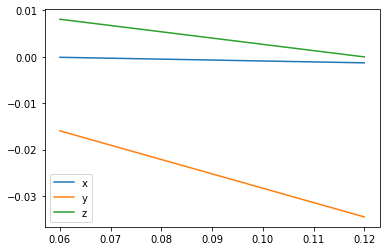

In [14]:
plt.plot(results['time'], results['x'], label='x')
plt.plot(results['time'], results['y'], label='y')
plt.plot(results['time'], results['z'], label='z')
plt.legend()
_ = plt.ylim()

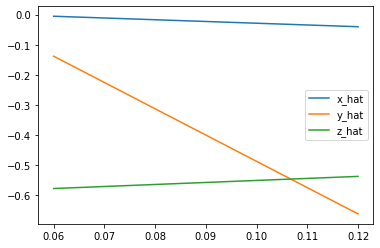

In [15]:
plt.plot(results['time'], results['x_velocity'], label='x_hat')
plt.plot(results['time'], results['y_velocity'], label='y_hat')
plt.plot(results['time'], results['z_velocity'], label='z_hat')
plt.legend()
_ = plt.ylim()

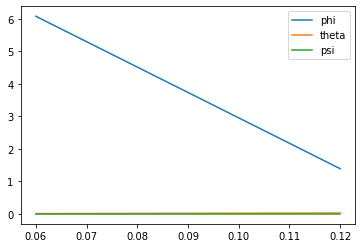

In [16]:
plt.plot(results['time'], results['phi'], label='phi')
plt.plot(results['time'], results['theta'], label='theta')
plt.plot(results['time'], results['psi'], label='psi')
plt.legend()
_ = plt.ylim()

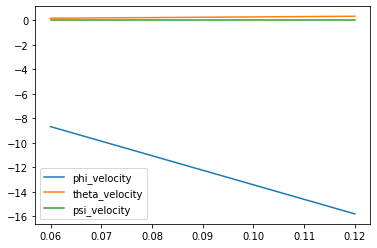

In [17]:
plt.plot(results['time'], results['phi_velocity'], label='phi_velocity')
plt.plot(results['time'], results['theta_velocity'], label='theta_velocity')
plt.plot(results['time'], results['psi_velocity'], label='psi_velocity')
plt.legend()
_ = plt.ylim()

In [18]:
# the pose, velocity, and angular velocity of the Quadcopter at the end of the episode
print(task.sim.pose)
print(task.sim.v)
print(task.sim.angular_v)

[-1.27894251e-03 -3.44694314e-02  0.00000000e+00  1.39174500e+00
  2.82208738e-02  0.00000000e+00]
[-0.04028314 -0.66321629 -0.5383543 ]
[-15.80831463   0.34724298   0.        ]


Final Performance (Mean Reward over last 10 episodes): 142.2337613609141


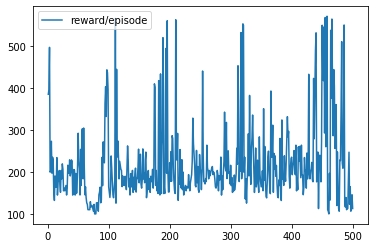

In [19]:

plt.plot(reward_results['episode'], reward_results['reward'], label='reward/episode')
plt.legend()
_ = plt.ylim()

# final performance 
print("Mean Reward over last 10 episodes: {}".format(np.sum(reward_results['reward'][-10:])/10))